<style>
  .contenedor-flex {
    display: flex;
    justify-content: flex-start;
    align-items: flex-start;
  }
  .imagen {
    margin-right: 20px;
  }
</style>

<div class="contenedor-flex">
  <div class="imagen">
    <img src="https://seeklogo.com/images/P/pontificia-universidad-javeriana-logo-D073FD2B47-seeklogo.com.png" width="150" alt="Logo Javeriana">
  </div>
  <div>
    <br><strong>Pontificia Universidad Javeriana</strong><br>
    <strong>Autor:</strong> Cesar Ramiro Beltrán Hernández<br>
    <strong>Fecha:</strong> 18-nov-2024<br>
    <strong>Cuaderno:</strong> Primer Laboratorio Spark<br>
    <strong>Tema:</strong> Limpieza de Datos y predicción usando <em>PySpark</em><br>
    <strong>Asignatura:</strong> Computación de Alto Desempeño<br>
     <strong>Docente:</strong> John Corredor, Ph.D.<br>
    <strong>Dataset:</strong> <a href="https://github.com/corredor-john/ExploratoryDataAnalisys/blob/main/Varios/stroke_pyspark.csv">Link al dataset</a>
  </div>
</div>


###Introducción

En este laboratorio, se usó PySpark para procesar grandes volúmenes de datos y realizar predicciones. Se lleva a cabo la limpieza de un dataset y se aplican modelos de aprendizaje automático para obtener predicciones en un entorno de computación de alto rendimiento.
Para el desarroyo de este trabajo se usó el dataset *stroke* el cual contiene información demográfica, de estilo de vida y de salud de diferentes individuos y caracteristicas relacionadas con accidentes cerebrovasculares.


###Observaciones
Durante el desarrollo del proyecto se observaron varios puntos relevantes:

**Preprocesamiento de Datos**: La fase inicial incluyó la conversión de variables categóricas a formato numérico, el manejo de valores nulos y la creación de un vector de características, estas acciones fueron esenciales para garantizar la calidad del modelo.

**Modelos Probados**: Se emplearon modelos de regresión logística y un clasificador de Random Forest para realizar las predicciones. Estis modelos se evaluaron en términos de precisión, tasa de falsos positivos y área bajo la curva (AUC).

**Desempeño**: El análisis de los resultados mostró que el modelo de Random Forest proporcionó un rendimiento sólido en comparación con la regresión logística, asímismo la curva ROC para ambos modelos indicó una AUC de aproximadamente 0.84, lo cual sugiere un desempeño adecuado en la predicción.


Se instalan librerias necesarias para Spark:
- numpy
- seaborn
- Matplotlib
- scikt-learn
- squarify


In [0]:
!pip install numpy
!pip install pyspark
!pip install seaborn
!pip install findspark
!pip install matplotlib
!pip install tabulate

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 867.2 kB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.5/200.5 kB 22.7 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.5.3-py2.py3-none-any.whl size=317840633 sha256=def6c078a79f13a8493ef79d5731e4264932e5b19e3423f3eb10e0f0bb5a88a8
  Stored in directory: /root/.cache/pip/wheels/2a/53/7b/362c2fe2d1fdd6bae33a4e5007ad032093b9ca6286be61134c
Successfully built pyspark
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to rest

In [0]:
### se invocan bibliotecas
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pyspark

from pyspark.context import SparkContext
from pyspark.sql import SQLContext, SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import input_file_name, mean, col, split, regexp_extract, when, lit, isnan, count
from pyspark import SparkFiles

from pyspark.conf import SparkConf
import os 


### Se configura Entorno PySpark
Se realiza Configuración de SparkContext y SparkSessio

In [0]:
SPARK_MASTER_URL = os.getenv("SPARK_MASTER_URL","spark://dos01:7077")
configura=SparkConf()
configura.setMaster(SPARK_MASTER_URL)
configura.set('spark.local.dir','/almacen/TrabajosSpark/')
configura.setAppName("Proyecto00_Spark_Stroke_Beltran")

configura.set('spark.cores.max',6)
configura.set('spark.executor.cores',6)

spark = SparkSession.builder.config(conf=configura).getOrCreate()
SQLContext(sparkContext=spark.sparkContext, sparkSession=spark)

print("Sesion creada: HPC")
spark

### Carga de Datos y Lectura de Archivos
Se lee el archivo CSV con la opción de encabezado y detección de esquema.

In [0]:
###Dataset: https://github.com/corredor-john/ExploratoryDataAnalisys/blob/main/Varios/stroke_pyspark.csv

url ="/FileStore/tables/stroke_pyspark.csv"
df00Stroke00 = spark.read.csv(url, header=True, inferSchema=True)


# Muestra las primeras 5 filas del DataFrame.
df00Stroke00.show(2)




+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|   id|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|
+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
| 9046|  Male|67.0|           0|            1|         Yes|      Private|         Urban|           228.69|36.6|formerly smoked|     1|
|51676|Female|61.0|           0|            0|         Yes|Self-employed|         Rural|           202.21| N/A|   never smoked|     1|
+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
only showing top 2 rows



### Entendiendo la estructura del dataFrame
Se imprime el nombre de las columnas y la estructura de cada una de ellas

In [0]:
#Nombre de columnas
df00Stroke00.columns

['id',
 'gender',
 'age',
 'hypertension',
 'heart_disease',
 'ever_married',
 'work_type',
 'Residence_type',
 'avg_glucose_level',
 'bmi',
 'smoking_status',
 'stroke']

In [0]:
### Tipo de datos
df00Stroke00.printSchema()

root
 |-- id: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: string (nullable = true)
 |-- smoking_status: string (nullable = true)
 |-- stroke: integer (nullable = true)



###Exploración y Limpieza de Datos
Asignación de Nuevos Nombres de Columnas:


In [0]:
### Se requiere cambiar los nombres de las Columnas
nuevosNombres = ['ID','Genero', 'Edad', 'Hipertension', 'Enfermedad', 'Casado', 'Trabajo', 'Tipo_Residencia', 
                 'Nivel_Prom_GlucosA', 'IMC', 'Fumador', 'Paro_Cardiaco']
df00Stroke01= df00Stroke00

###Bucle para cambio de nombre
for antes, nuevo in zip(df00Stroke01.columns, nuevosNombres):
        df00Stroke01= df00Stroke01.withColumnRenamed(antes, nuevo)


df00Stroke01.columns

['ID',
 'Genero',
 'Edad',
 'Hipertension',
 'Enfermedad',
 'Casado',
 'Trabajo',
 'Tipo_Residencia',
 'Nivel_Prom_GlucosA',
 'IMC',
 'Fumador',
 'Paro_Cardiaco']

Cambio del Tipo de Dato de la Columna '**IMC**' a **DoubleType**


In [0]:
### Se requiere cambiar los nombres de las Columnas

df00Stroke01=df00Stroke01.withColumn('IMC', df00Stroke01.IMC.cast(DoubleType()))
df00Stroke01.printSchema()


root
 |-- ID: integer (nullable = true)
 |-- Genero: string (nullable = true)
 |-- Edad: double (nullable = true)
 |-- Hipertension: integer (nullable = true)
 |-- Enfermedad: integer (nullable = true)
 |-- Casado: string (nullable = true)
 |-- Trabajo: string (nullable = true)
 |-- Tipo_Residencia: string (nullable = true)
 |-- Nivel_Prom_GlucosA: double (nullable = true)
 |-- IMC: double (nullable = true)
 |-- Fumador: string (nullable = true)
 |-- Paro_Cardiaco: integer (nullable = true)



Conteo de Valores Nulos por Columna

In [0]:
### pend foto

df00Stroke01.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df00Stroke01.columns]).show()

+---+------+----+------------+----------+------+-------+---------------+------------------+---+-------+-------------+
| ID|Genero|Edad|Hipertension|Enfermedad|Casado|Trabajo|Tipo_Residencia|Nivel_Prom_GlucosA|IMC|Fumador|Paro_Cardiaco|
+---+------+----+------------+----------+------+-------+---------------+------------------+---+-------+-------------+
|  0|     0|   0|           0|         0|     0|      0|              0|                 0|201|      0|            0|
+---+------+----+------------+----------+------+-------+---------------+------------------+---+-------+-------------+



Conteo Total de Filas en el DataFrame

In [0]:
df00Stroke01.count()

5110

Cálculo del Porcentaje de Valores Nulos en la Columna 'IMC'

In [0]:
#201 = Num de valores nulos en columna IMC

nulos= (201/df00Stroke01.count())*100     #Calcula el porcentaje
print(f"Se tiene una porción de {round(nulos,2)}%")

Se tiene una porción de 3.93%


Conteo de Registros por Género en el DataFrame

In [0]:
## Se observa las categorias Género, realiza el conteo y los imprime.

df00Stroke01.groupby(["Genero"]).count().show()


+------+-----+
|Genero|count|
+------+-----+
|Female| 2994|
| Other|    1|
|  Male| 2115|
+------+-----+



Filtrado y Conteo de Registros por Género (Excluyendo 'Other')

In [0]:

##Se elimina el Other en los Datos
df00Stroke02= df00Stroke01.where("Genero <> 'Other'")   #excluye las filas donde la columna 'Genero' tenga el valor 'Other'
df00Stroke02.groupby(['Genero']).count().show()         #conteo por género


+------+-----+
|Genero|count|
+------+-----+
|Female| 2994|
|  Male| 2115|
+------+-----+



Cálculo del Promedio de IMC para Mujeres Menores de 10 Años

In [0]:
###Se estrarifica por edades y por genero, de manera que cada 10 años se saca el promedio  IMC y por genero.

#Filtra Genero = Female y Edad < 10.
#Calcula el promedio de la columna IMC para las filas que cumplen las condiciones previas
AvIMC_0_10 = df00Stroke02.where((col("Genero") == lit("Female")) & (col("Edad")<10)).select(mean(col("IMC"))).collect()[0][0]
print("Promedio IMC para mujeres menores de 10 años", AvIMC_0_10)

Promedio IMC para mujeres menores de 10 años 18.687962962962963


Función para Calcular Promedio y Reemplazar Valores Nulos en una Columna

In [0]:
#Se hace la funcion que calcula un promedio y reemplaza valores nulos del Dataframe


def cambioPromedio(df, col01, catGenero, col02, minEdad, maxEdad, col03):

    # Calcula el promedio de la columna `col03` filtrando por `col01` (por ejemplo, 'Genero') y rango de edades
    prom = df.where((col(col01) == lit(catGenero)) & (col(col02) > minEdad) & (col(col02) < maxEdad)).select(mean(col(col03))).collect()[0][0]
    print(prom)

    # Crea un nuevo DataFrame `dfResul` donde los valores nulos de `col03` se reemplazan por el promedio `prom`
    dfResul = df.withColumn(col03, when(((df[col01] == catGenero) & (df[col03].isNull()) & (df[col02]<maxEdad)), prom).otherwise(df[col03]))
    
    # Retorna el DataFrame resultante con la columna actualizada
    return dfResul



Visualización del Promedio de IMC Calculado y Conteo de Valores Nulos Restantes

In [0]:
# Llama a la función y guarda el DataFrame resultante
dfActualizado = cambioPromedio(df00Stroke02, "Genero", "Female", "Edad", 0, 10, "IMC")

print(f"El promedio de IMC para mujeres menores de 10 años es: {round(AvIMC_0_10, 2)}")

print("Vista previa de las primeras 5 filas del DataFrame actualizado:")
dfActualizado.show(5)

# Verifica cuántos valores nulos quedan en la columna 'IMC'
num_nulos_restantes = dfActualizado.select("IMC").filter(col("IMC").isNull()).count()
print(f"El número de valores nulos restantes en la columna 'IMC' es: {num_nulos_restantes}")



18.687962962962963
El promedio de IMC para mujeres menores de 10 años es: 18.69
Vista previa de las primeras 5 filas del DataFrame actualizado:
+-----+------+----+------------+----------+------+-------------+---------------+------------------+----+---------------+-------------+
|   ID|Genero|Edad|Hipertension|Enfermedad|Casado|      Trabajo|Tipo_Residencia|Nivel_Prom_GlucosA| IMC|        Fumador|Paro_Cardiaco|
+-----+------+----+------------+----------+------+-------------+---------------+------------------+----+---------------+-------------+
| 9046|  Male|67.0|           0|         1|   Yes|      Private|          Urban|            228.69|36.6|formerly smoked|            1|
|51676|Female|61.0|           0|         0|   Yes|Self-employed|          Rural|            202.21|NULL|   never smoked|            1|
|31112|  Male|80.0|           0|         1|   Yes|      Private|          Rural|            105.92|32.5|   never smoked|            1|
|60182|Female|49.0|           0|         0|   

###Relleno de Valores Nulos en IMC por Intervalos de Edad de 10 Años para Mujeres
Rellena los valores nulos en la columna IMC del DataFrame para mujeres, dividiendo los datos en intervalos de edad de 10 años. Se calcula el promedio de IMC para cada intervalo (0-10, 10-20, etc.) y se utiliza ese promedio para reemplazar los valores nulos en la columna IMC de las mujeres en ese rango de edad. Al final, se imprime el último rango de edad procesado para confirmar que se completó el bucle.

In [0]:
df00Stroke03 = df00Stroke02
for promedio in range(0,100,10):
    df00Stroke03 = cambioPromedio(df00Stroke03, "Genero", "Female", "Edad", promedio, promedio+10, "IMC")
print(promedio, promedio+10)


18.687962962962963
25.553556485355664
28.418373493975906
31.142359249329765
31.123333333333324
31.915686274509792
30.62181208053691
29.3374558303887
28.101428571428578
None
90 100


Visualización de Promedios de IMC por Intervalos de Edad

In [0]:
from pyspark.sql import Row
resultados_promedios = []

# Itera sobre los intervalos de edad y calcula los promedios de IMC
for promedio in range(0, 100, 10):
    promedio_calculado = df00Stroke03.where(
        (col("Genero") == lit("Female")) &  (col("Edad") > promedio) & (col("Edad") < promedio + 10)).select(mean(col("IMC"))).collect()[0][0]  # Calcula el promedio de IMC
    resultados_promedios.append(Row(Rango_Edad_Inicio=promedio, Rango_Edad_Fin=promedio + 10, Promedio_IMC=promedio_calculado))

# Crea un nuevo df  a partir de la lista de resultados
df_resultados_spark = spark.createDataFrame(resultados_promedios)

print("\nTabla de promedios de IMC por rango de edad:")
df_resultados_spark.show(truncate=False)



Tabla de promedios de IMC por rango de edad:
+-----------------+--------------+------------------+
|Rango_Edad_Inicio|Rango_Edad_Fin|Promedio_IMC      |
+-----------------+--------------+------------------+
|0                |10            |18.68796296296296 |
|10               |20            |25.553556485355667|
|20               |30            |28.418373493975906|
|30               |40            |31.142359249329775|
|40               |50            |31.12333333333332 |
|50               |60            |31.915686274509778|
|60               |70            |30.621812080536895|
|70               |80            |29.33745583038868 |
|80               |90            |28.101428571428578|
|90               |100           |NULL              |
+-----------------+--------------+------------------+



In [0]:
# Muestra las primeras 5 filas del DataFrame.
df00Stroke03.show(5)


+-----+------+----+------------+----------+------+-------------+---------------+------------------+-----------------+---------------+-------------+
|   ID|Genero|Edad|Hipertension|Enfermedad|Casado|      Trabajo|Tipo_Residencia|Nivel_Prom_GlucosA|              IMC|        Fumador|Paro_Cardiaco|
+-----+------+----+------------+----------+------+-------------+---------------+------------------+-----------------+---------------+-------------+
| 9046|  Male|67.0|           0|         1|   Yes|      Private|          Urban|            228.69|             36.6|formerly smoked|            1|
|51676|Female|61.0|           0|         0|   Yes|Self-employed|          Rural|            202.21|30.62181208053691|   never smoked|            1|
|31112|  Male|80.0|           0|         1|   Yes|      Private|          Rural|            105.92|             32.5|   never smoked|            1|
|60182|Female|49.0|           0|         0|   Yes|      Private|          Urban|            171.23|             

Visualización Grafica con matplotlib

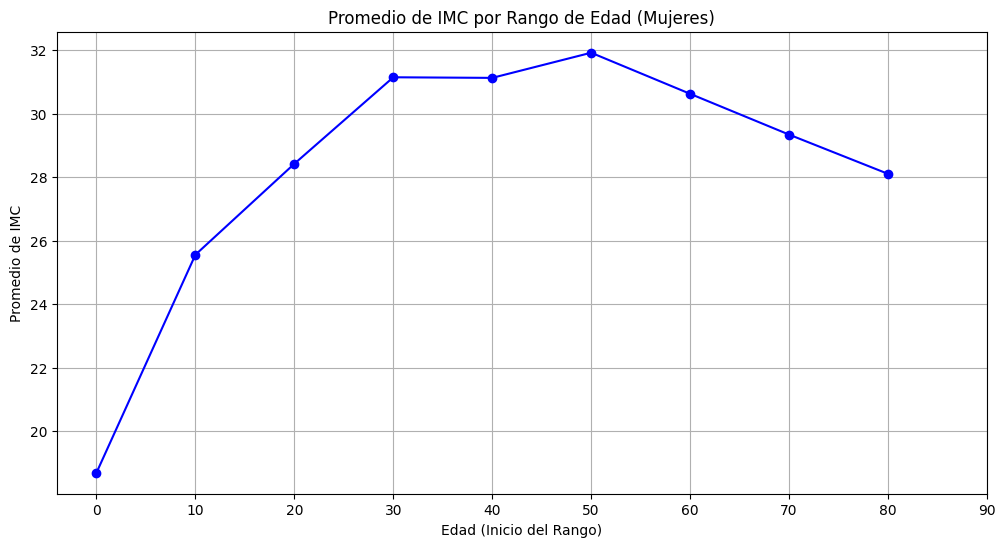

In [0]:
import matplotlib.pyplot as plt

# Convierte el DataFrame de PySpark a un DataFrame de Pandas para facilitar la visualización
df_resultados_pandas = df_resultados_spark.toPandas()

plt.figure(figsize=(12, 6))
plt.plot(df_resultados_pandas['Rango_Edad_Inicio'], df_resultados_pandas['Promedio_IMC'], marker='o', linestyle='-', color='b')

plt.title('Promedio de IMC por Rango de Edad (Mujeres)')
plt.xlabel('Edad (Inicio del Rango)')
plt.ylabel('Promedio de IMC')
plt.xticks(df_resultados_pandas['Rango_Edad_Inicio'])
plt.grid(True)

plt.show()


In [0]:
df00Stroke03.show(5)
df00Stroke03.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df00Stroke03.columns]).show()

+-----+------+----+------------+----------+------+-------------+---------------+------------------+-----------------+---------------+-------------+
|   ID|Genero|Edad|Hipertension|Enfermedad|Casado|      Trabajo|Tipo_Residencia|Nivel_Prom_GlucosA|              IMC|        Fumador|Paro_Cardiaco|
+-----+------+----+------------+----------+------+-------------+---------------+------------------+-----------------+---------------+-------------+
| 9046|  Male|67.0|           0|         1|   Yes|      Private|          Urban|            228.69|             36.6|formerly smoked|            1|
|51676|Female|61.0|           0|         0|   Yes|Self-employed|          Rural|            202.21|30.62181208053691|   never smoked|            1|
|31112|  Male|80.0|           0|         1|   Yes|      Private|          Rural|            105.92|             32.5|   never smoked|            1|
|60182|Female|49.0|           0|         0|   Yes|      Private|          Urban|            171.23|             

###Uso de libreria MLlib



1. Preparación del Entorno


In [0]:
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.functions import col


2. Preprocesamiento de los Datos


In [0]:
#Indexa columnas categoricas
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline

# Indexa las columnas categóricas
indexer_genero = StringIndexer(inputCol="Genero", outputCol="Genero_Idx")
indexer_trabajo = StringIndexer(inputCol="Trabajo", outputCol="Trabajo_Idx")
indexer_residencia = StringIndexer(inputCol="Tipo_Residencia", outputCol="Residencia_Idx")
indexer_fumador = StringIndexer(inputCol="Fumador", outputCol="Fumador_Idx")
indexer_casado = StringIndexer(inputCol="Casado", outputCol="Casado_Idx")

# Aplica los indexadores en un pipeline
pipeline = Pipeline(stages=[indexer_genero, indexer_trabajo, indexer_residencia, indexer_fumador, indexer_casado])
df_indexed = pipeline.fit(df00Stroke03).transform(df00Stroke03)





2. Manejo de los valores nulos


In [0]:
# Reemplaza valores nulos en columnas numéricas con 0 o un valor adecuado
df_indexed = df_indexed.fillna(0, subset=["Edad", "Hipertension", "Enfermedad", "Nivel_Prom_GlucosA", "IMC"])

# Reemplaza valores nulos en columnas categóricas indexadas
df_indexed = df_indexed.fillna("Desconocido", subset=["Genero_Idx", "Casado_Idx", "Trabajo_Idx", "Residencia_Idx", "Fumador_Idx"])


In [0]:
# Verifica que todas las columnas se hayan añadido correctamente
print(df_indexed.columns)


['ID', 'Genero', 'Edad', 'Hipertension', 'Enfermedad', 'Casado', 'Trabajo', 'Tipo_Residencia', 'Nivel_Prom_GlucosA', 'IMC', 'Fumador', 'Paro_Cardiaco', 'Genero_Idx', 'Trabajo_Idx', 'Residencia_Idx', 'Fumador_Idx', 'Casado_Idx']


3. Crear un Vector de Características

In [0]:
from pyspark.ml.feature import VectorAssembler

# Define las columnas de características
feature_cols = ["Genero_Idx", "Edad", "Hipertension", "Enfermedad", "Casado_Idx", "Trabajo_Idx", 
                "Residencia_Idx", "Nivel_Prom_GlucosA", "IMC", "Fumador_Idx"]

# Ensambla las características
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features", handleInvalid="keep")
df_final = assembler.transform(df_indexed)



4. Dividir los Datos en Entrenamiento y Prueba


In [0]:
# Divide el DataFrame en conjuntos de entrenamiento y prueba
train_df, test_df = df_final.randomSplit([0.7, 0.3], seed=42)


6. Entrenamiento del modelo de clasificación

In [0]:
from pyspark.ml.classification import LogisticRegression

# Entrena el modelo de regresión logística
lr = LogisticRegression(labelCol="Paro_Cardiaco", featuresCol="features")
lr_model = lr.fit(train_df)


7. Evaluación del modelo

In [0]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Realiza las predicciones
predictions = lr_model.transform(test_df)
predictions.select("features", "Paro_Cardiaco", "prediction", "probability").show(10)

# Evalúa el modelo
evaluator = BinaryClassificationEvaluator(labelCol="Paro_Cardiaco")
auc = evaluator.evaluate(predictions)
print(f"Área bajo la curva (AUC): {auc:.2f}")




+--------------------+-------------+----------+--------------------+
|            features|Paro_Cardiaco|prediction|         probability|
+--------------------+-------------+----------+--------------------+
|(10,[0,1,7,8],[1....|            0|       0.0|[0.97668758677242...|
|(10,[1,4,7,8],[24...|            0|       0.0|[0.99657448989275...|
|(10,[1,6,7,8],[33...|            0|       0.0|[0.99518484172739...|
|[0.0,20.0,0.0,0.0...|            0|       0.0|[0.99658532191746...|
|(10,[1,6,7,8,9],[...|            0|       0.0|[0.98754048433077...|
|[1.0,81.0,0.0,0.0...|            1|       0.0|[0.85763655946501...|
|(10,[1,4,7,8],[23...|            0|       0.0|[0.99670221844515...|
|(10,[0,1,7,8],[1....|            0|       0.0|[0.80028732034414...|
|(10,[0,1,6,7,8],[...|            0|       0.0|[0.98938650411353...|
|(10,[1,6,7,8],[43...|            0|       0.0|[0.98661608266479...|
+--------------------+-------------+----------+--------------------+
only showing top 10 rows

Área baj

8. Visualización gráfica

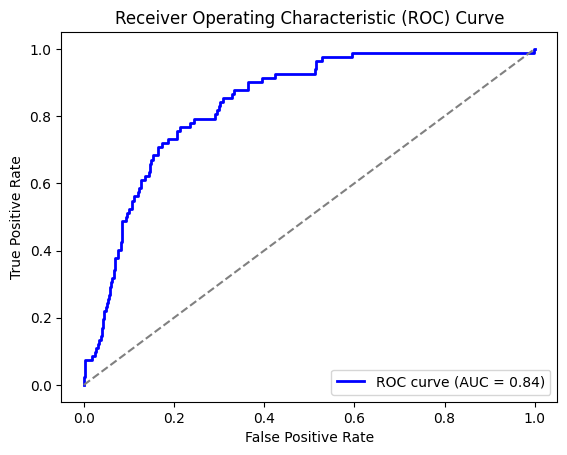

In [0]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import matplotlib.pyplot as plt
import numpy as np

# Evaluador
evaluator = BinaryClassificationEvaluator(labelCol="Paro_Cardiaco", rawPredictionCol="probability", metricName="areaUnderROC")
roc_auc = evaluator.evaluate(predictions)

# Asumiendo que tienes un array de probabilidades predichas y etiquetas reales
probabilities = np.array(predictions.select("probability").rdd.map(lambda row: row[0][1]).collect())
labels = np.array(predictions.select("Paro_Cardiaco").rdd.map(lambda row: row).collect())

# Calcula la curva ROC
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(labels, probabilities)
roc_auc_value = auc(fpr, tpr)

# Plot de la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc_value:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


###Predicción con algoritmo Random forest

In [0]:
from pyspark.ml.classification import RandomForestClassifier
# Entrena el modelo de clasificación con RandomForestClassifier
rf = RandomForestClassifier(labelCol="Paro_Cardiaco", featuresCol="features", numTrees=100)
rf_model = rf.fit(train_df)


In [0]:
# Realiza las predicciones
predictions_rf = rf_model.transform(test_df)
predictions_rf.select("features", "Paro_Cardiaco", "prediction", "probability").show(5)


+--------------------+-------------+----------+--------------------+
|            features|Paro_Cardiaco|prediction|         probability|
+--------------------+-------------+----------+--------------------+
|(10,[0,1,7,8],[1....|            0|       0.0|[0.97355962277908...|
|(10,[1,4,7,8],[24...|            0|       0.0|[0.98370547890324...|
|(10,[1,6,7,8],[33...|            0|       0.0|[0.97796406717902...|
|[0.0,20.0,0.0,0.0...|            0|       0.0|[0.98425785583648...|
|(10,[1,6,7,8,9],[...|            0|       0.0|[0.97799471924194...|
+--------------------+-------------+----------+--------------------+
only showing top 5 rows



In [0]:
# Evalúa el modelo de RandomForest
evaluator_rf = BinaryClassificationEvaluator(labelCol="Paro_Cardiaco")
auc_rf = evaluator_rf.evaluate(predictions_rf)
print(f"Área bajo la curva (AUC) para RandomForest: {auc_rf:.2f}")


Área bajo la curva (AUC) para RandomForest: 0.84


### Conclusiones
El uso de PySpark permitió realizar un análisis y modelado eficiente de grandes volúmenes de datos, aprovechando las capacidades de sistemas distribuidos y entornos HPC para reducir los tiempos de procesamiento. Esto es útil para manejar grandes cantidades de datos de manera rápida y eficiente.

El modelo de predicción de paro cardíaco alcanzó un AUC de 0.84, indicando un buen desempeño en la discriminación entre casos positivos y negativos. Aun así, hay espacio para mejorar. Estrategias como un preprocesamiento de datos más exhaustivo y la optimización de los hiperparámetros del modelo podrían ayudar a aumentar su rendimiento.

La fase de preprocesamiento es importante en proyectos de análisis y modelado de datos, ya que afecta directamente la calidad y rendimiento del modelo. Un buen preprocesamiento mejora la precisión, mientras que un mal manejo de los datos puede afectarla. Técnicas como la limpieza de datos, la imputación de valores nulos y la transformación de variables categóricas ayudan a optimizar la capacidad predictiva del modelo y a reducir el ruido en los datos.

En general, PySpark demostró ser efectivo para tareas de análisis y modelado de datos a gran escala. Implementar mejoras adicionales podría llevar a un rendimiento más alto y modelos más precisos.

###Recomendaciones
Implementar técnicas de preprocesamiento más detalladas, con el fin de mejorar la calidad del modelo.

Implementar validación cruzada para evitar el sobreajuste y a evaluar mejor el rendimiento del modelo.

Probar otros algoritmos de clasificación como Gradient Boosted Trees para comparar resultados y mejorar el desempeño.